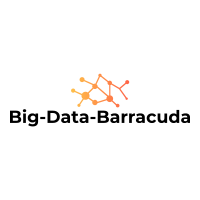 <h1 align=center><font size = 5>Waffle Charts, Word Clouds, and Regression Plots</font></h1>

### Downloading and Prepping Data

In [1]:
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
from PIL import Image # converting images into arrays

In [2]:
!conda install -c anaconda xlrd --yes

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - xlrd


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.1.1   |                0         132 KB  anaconda
    certifi-2020.4.5.1         |           py36_0         159 KB  anaconda
    openssl-1.1.1g             |       h7b6447c_0         3.8 MB  anaconda
    xlrd-1.2.0                 |           py36_0         188 KB  anaconda
    ------------------------------------------------------------
                                           Total:         4.3 MB

The following packages will be UPDATED:

  openssl            conda-forge::openssl-1.1.1f-h516909a_0 --> anaconda::openssl-1.1.1g-h7b6447c_0

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2020.4.5~ --> a

In [3]:
# Download dataset
df_can = pd.read_excel('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Data_Files/Canada.xlsx',
                       sheet_name='Canada by Citizenship',
                       skiprows=range(20),
                       skipfooter=2)

print('Data downloaded and read into a dataframe!')

Data downloaded and read into a dataframe!


In [4]:
# Review 
df_can.head()

,Type,Coverage,OdName,AREA,AreaName,REG,RegName,DEV,DevName,1980,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,Immigrants,Foreigners,Afghanistan,935,Asia,5501,Southern Asia,902,Developing regions,16,...,2978,3436,3009,2652,2111,1746,1758,2203,2635,2004
1,Immigrants,Foreigners,Albania,908,Europe,925,Southern Europe,901,Developed regions,1,...,1450,1223,856,702,560,716,561,539,620,603
2,Immigrants,Foreigners,Algeria,903,Africa,912,Northern Africa,902,Developing regions,80,...,3616,3626,4807,3623,4005,5393,4752,4325,3774,4331
3,Immigrants,Foreigners,American Samoa,909,Oceania,957,Polynesia,902,Developing regions,0,...,0,0,1,0,0,0,0,0,0,0
4,Immigrants,Foreigners,Andorra,908,Europe,925,Southern Europe,901,Developed regions,0,...,0,0,1,1,0,0,0,0,1,1


In [5]:
# print the dimensions of the dataframe
print(df_can.shape)

(195, 43)


In [6]:
# clean up the dataset to remove unnecessary columns (eg. REG) 
df_can.drop(['AREA','REG','DEV','Type','Coverage'], axis = 1, inplace = True)

# let's rename the columns so that they make sense
df_can.rename (columns = {'OdName':'Country', 'AreaName':'Continent','RegName':'Region'}, inplace = True)

# for sake of consistency, let's also make all column labels of type string
df_can.columns = list(map(str, df_can.columns))

# set the country name as index - useful for quickly looking up countries using .loc method
df_can.set_index('Country', inplace = True)

# add total column
df_can['Total'] =  df_can.sum (axis = 1)

# years that we will be using in this lesson - useful for plotting later on
years = list(map(str, range(1980, 2014)))
print ('data dimensions:', df_can.shape)

data dimensions: (195, 38)


# Visualizing Data using Matplotlib

In [7]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # needed for waffle Charts

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) 

Matplotlib version:  3.1.1


# Waffle Charts 

In [58]:
# Denmark, Sweden, Norway case study
df_dsn = df_can.loc[['Denmark', 'Norway', 'Sweden'], :]
df_dsn

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,
Denmark,Europe,Northern Europe,Developed regions,272,293,299,106,93,73,93,...,62,101,97,108,81,92,93,94,81,3901
Norway,Europe,Northern Europe,Developed regions,116,77,106,51,31,54,56,...,57,53,73,66,75,46,49,53,59,2327
Sweden,Europe,Northern Europe,Developed regions,281,308,222,176,128,158,187,...,205,139,193,165,167,159,134,140,140,5866


**Step 1.** The first step into creating a waffle chart is determining the proportion of each category with respect to the total.

In [59]:
# compute the proportion of each category with respect to the total
total_values = sum(df_dsn['Total'])
category_proportions = [(float(value) / total_values) for value in df_dsn['Total']]

# print out proportions
for i, proportion in enumerate(category_proportions):
    print (df_dsn.index.values[i] + ': ' + str(proportion))

Denmark: 0.32255663965602777
Norway: 0.1924094592359848
Sweden: 0.48503390110798744


**Step 2.** The second step is defining the overall size of the `waffle` chart.

In [60]:
width = 40 # width of chart
height = 10 # height of chart

total_num_tiles = width * height # total number of tiles

print ('Total number of tiles is ', total_num_tiles)

Total number of tiles is  400


**Step 3.** The third step is using the proportion of each category to determine it respective number of tiles.

In [61]:
# compute the number of tiles for each catagory
tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

# print out number of tiles per category
for i, tiles in enumerate(tiles_per_category):
    print (df_dsn.index.values[i] + ': ' + str(tiles))

Denmark: 129
Norway: 77
Sweden: 194


**Step 4.** The fourth step is creating a matrix that resembles the `waffle` chart and populating it.

In [62]:
# initialize the waffle chart as an empty matrix
waffle_chart = np.zeros((height, width))

# define indices to loop through waffle chart
category_index = 0
tile_index = 0

# populate the waffle chart
for col in range(width):
    for row in range(height):
        tile_index += 1

        # if the number of tiles populated for the current category is equal to its corresponding allocated tiles...
        if tile_index > sum(tiles_per_category[0:category_index]):
            # ...proceed to the next category
            category_index += 1       
            
        # set the class value to an integer, which increases with class
        waffle_chart[row, col] = category_index
        
print ('Waffle chart populated!')

Waffle chart populated!


In [63]:
waffle_chart

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
   

**Step 5.** Map the `waffle` chart matrix into a visual.

<Figure size 432x288 with 0 Axes>

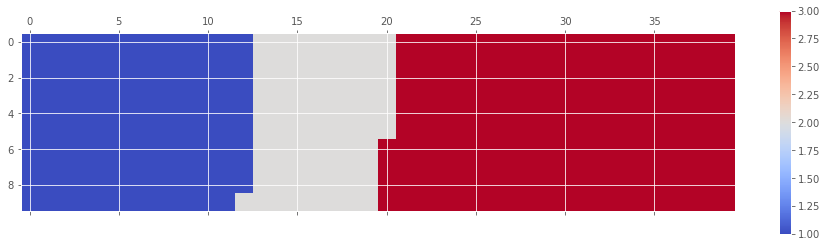

In [64]:
# instantiate a new figure object
fig = plt.figure()

# use matshow to display the waffle chart
colormap = plt.cm.coolwarm
plt.matshow(waffle_chart, cmap=colormap)
plt.colorbar()

**Step 6.** Edit the chart.

([], <a list of 0 Text yticklabel objects>)

<Figure size 432x288 with 0 Axes>

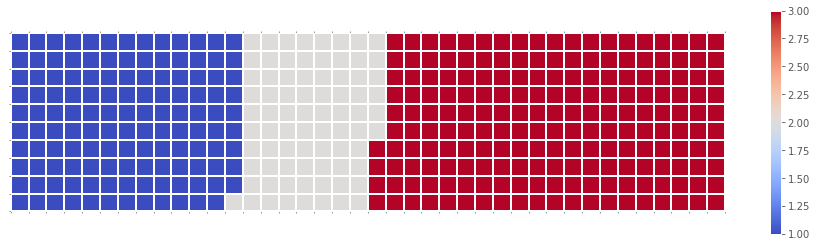

In [65]:
# instantiate a new figure object
fig = plt.figure()

# use matshow to display the waffle chart
colormap = plt.cm.coolwarm
plt.matshow(waffle_chart, cmap = colormap)
plt.colorbar()

# get the axis
ax = plt.gca()

# set minor ticks
ax.set_xticks(np.arange(-.5, (width), 1), minor = True)
ax.set_yticks(np.arange(-.5, (height), 1), minor = True)

# add gridlines
ax.grid(which = 'minor', color = 'w', linestyle = '-', linewidth = 2)

plt.xticks([])
plt.yticks([])

**Step 7.** Create a legend and add it to chart.

<Figure size 432x288 with 0 Axes>

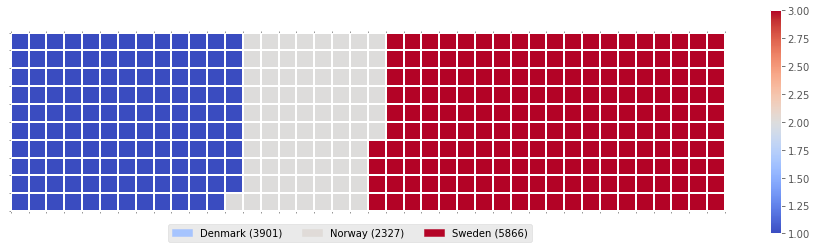

In [66]:
# instantiate a new figure object
fig = plt.figure()

# use matshow to display the waffle chart
colormap = plt.cm.coolwarm
plt.matshow(waffle_chart, cmap=colormap)
plt.colorbar()

# get the axis
ax = plt.gca()

# set minor ticks
ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
# add gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

plt.xticks([])
plt.yticks([])

# compute cumulative sum of individual categories to match color schemes between chart and legend
values_cumsum = np.cumsum(df_dsn['Total'])
total_values = values_cumsum[len(values_cumsum) - 1]

# create legend
legend_handles = []
for i, category in enumerate(df_dsn.index.values):
    label_str = category + ' (' + str(df_dsn['Total'][i]) + ')'
    color_val = colormap(float(values_cumsum[i])/total_values)
    legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

# add legend to chart
plt.legend(handles=legend_handles,
           loc='lower center', 
           ncol=len(df_dsn.index.values),
           bbox_to_anchor=(0., -0.2, 0.95, .1)
          )

# Word Clouds

In [67]:
# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - wordcloud==1.4.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    olefile-0.46               |             py_0          31 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    pillow-7.1.2               |   py36h8328e55_0         656 KB  conda-forge
    wordcloud-1.4.1            |           py36_0         324 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be INSTALLED:

  olefile            conda-forge/noarch::olefile-0.46-py_0
  pillow             conda-forge/linux-64::pillow-7.1.2-py36h8328

Let's try to analyze a short novel written by **Lewis Carroll** titled *Alice's Adventures in Wonderland*.

In [68]:
# download file and save as alice_novel.txt
!wget --quiet https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Data_Files/alice_novel.txt

# open the file and read it into a variable alice_novel
alice_novel = open('alice_novel.txt', 'r').read()
    
print ('File downloaded and saved!')

File downloaded and saved!


In [69]:
stopwords = set(STOPWORDS)

Create a word cloud object and generate a word cloud.

In [70]:
# instantiate a word cloud object
alice_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
alice_wc.generate(alice_novel)

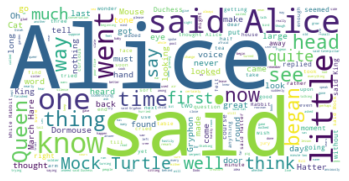

In [73]:
# display the word cloud
plt.imshow(alice_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

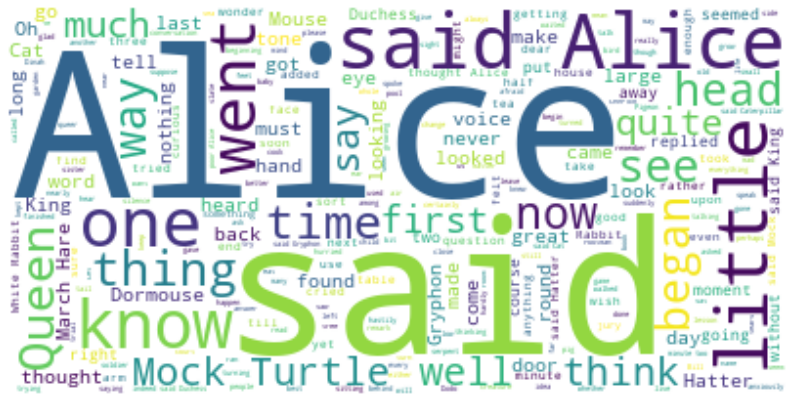

In [74]:
# Resize
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

# display the cloud
plt.imshow(alice_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

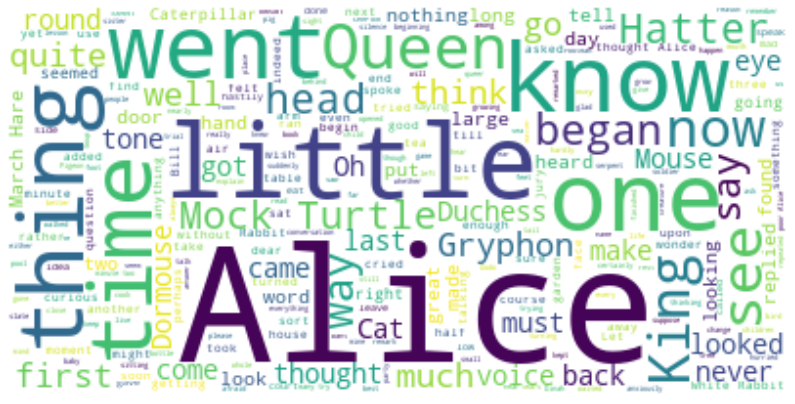

In [75]:
# Add said to stopwords
stopwords.add('said') # add the words said to stopwords

# re-generate the word cloud
alice_wc.generate(alice_novel)

# display the cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(alice_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Let's use a mask of Alice and her rabbit to superimpose our word cloud on to.

In [76]:
# download image
!wget --quiet https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Images/alice_mask.png
    
# save mask to alice_mask
alice_mask = np.array(Image.open('alice_mask.png'))
    
print('Image downloaded and saved!')

Image downloaded and saved!


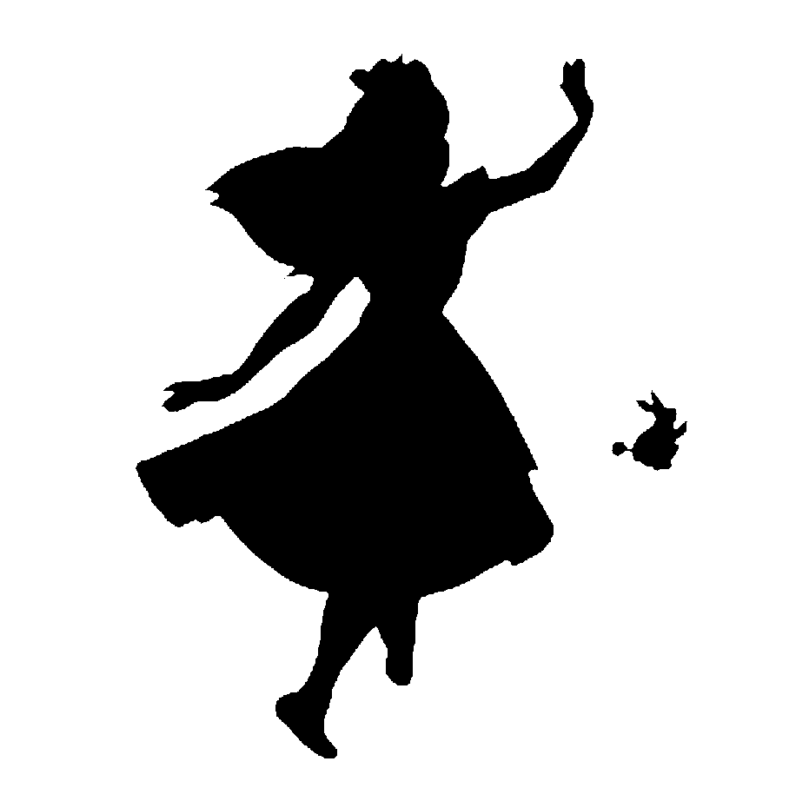

In [77]:
#View
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(alice_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis('off')
plt.show()

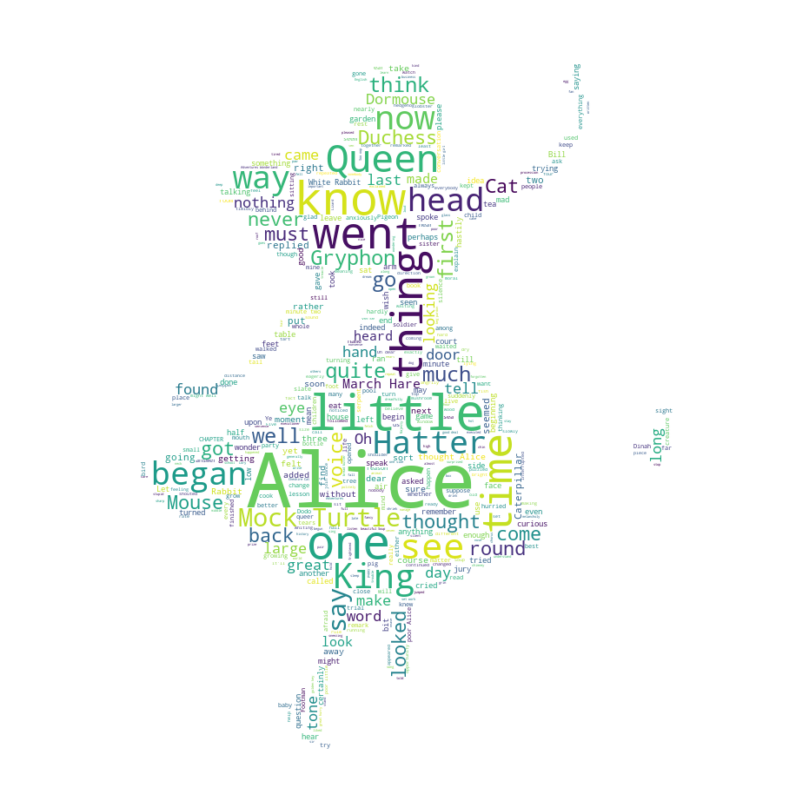

In [83]:
# instantiate a word cloud object
alice_wc = WordCloud(background_color='white', max_words=2000, mask=alice_mask, stopwords=stopwords)

# generate the word cloud
alice_wc.generate(alice_novel)

# display the word cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(alice_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Let's generate sample text data from our immigration dataset, say text data of 90 words.

In [84]:
df_can.head()

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Asia,Southern Asia,Developing regions,16,39,39,47,71,340,496,...,3436,3009,2652,2111,1746,1758,2203,2635,2004,58639
Albania,Europe,Southern Europe,Developed regions,1,0,0,0,0,0,1,...,1223,856,702,560,716,561,539,620,603,15699
Algeria,Africa,Northern Africa,Developing regions,80,67,71,69,63,44,69,...,3626,4807,3623,4005,5393,4752,4325,3774,4331,69439
American Samoa,Oceania,Polynesia,Developing regions,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,6
Andorra,Europe,Southern Europe,Developed regions,0,0,0,0,0,0,2,...,0,1,1,0,0,0,0,1,1,15


In [85]:
total_immigration = df_can['Total'].sum()
total_immigration

6409153

In [86]:
max_words = 90
word_string = ''
for country in df_can.index.values:
    # check if country's name is a single-word name
    if len(country.split(' ')) == 1:
        repeat_num_times = int(df_can.loc[country, 'Total']/float(total_immigration)*max_words)
        word_string = word_string + ((country + ' ') * repeat_num_times)
                                     
# display the generated text
word_string

'China China China China China China China China China Colombia Egypt France Guyana Haiti India India India India India India India India India Jamaica Lebanon Morocco Pakistan Pakistan Pakistan Philippines Philippines Philippines Philippines Philippines Philippines Philippines Poland Portugal Romania '

In [87]:
# create the word cloud
wordcloud = WordCloud(background_color='white').generate(word_string)

print('Word cloud created!')

Word cloud created!


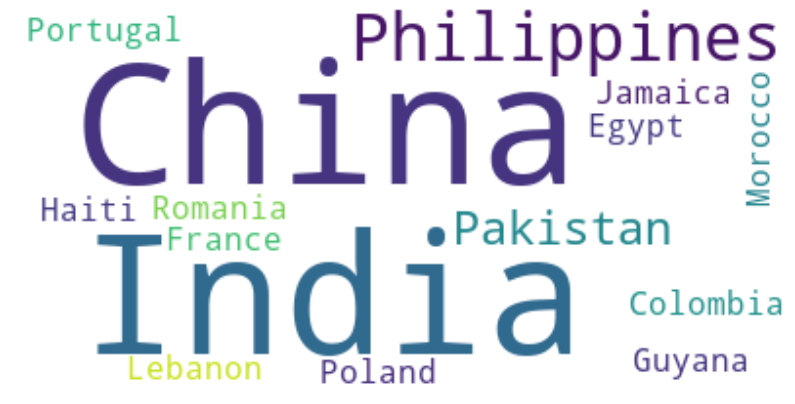

In [88]:
# display the cloud
fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(18)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Regression Plots 

In [89]:
# install seaborn
!conda install -c anaconda seaborn --yes

# import library
import seaborn as sns

print('Seaborn installed and imported!')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |         openblas          48 KB  anaconda
    dbus-1.13.12               |       h746ee38_0         501 KB
    gst-plugins-base-1.14.0    |       hbbd80ab_1         4.8 MB
    gstreamer-1.14.0           |       hb453b48_1         3.1 MB
    matplotlib-3.1.3           |           py36_0          21 KB  anaconda
    matplotlib-base-3.1.3      |   py36hef1b27d_0         6.6 MB  anaconda
    pandas-1.0.3               |   py36h0573a6f_0        11.1 MB  anaconda
    pyqt-5.9.2                 |   py36h22d08a2_1         5.6 MB  anaconda
    pytz-2019.3                |             py_0         231 KB  anaconda
    qt-5.9.7                   |       h5867ecd_1        68.5 M

Dataframe with total number of immigrants to Canada per year from 1980 to 2013.

In [90]:
# we can use the sum() method to get the total population per year
df_tot = pd.DataFrame(df_can[years].sum(axis=0))

# change the years to type float (useful for regression later on)
df_tot.index = map(float, df_tot.index)

# reset the index to put in back in as a column in the df_tot dataframe
df_tot.reset_index(inplace=True)

# rename columns
df_tot.columns = ['year', 'total']

# view the final dataframe
df_tot.head()

,year,total
0,1980.0,99137
1,1981.0,110563
2,1982.0,104271
3,1983.0,75550
4,1984.0,73417


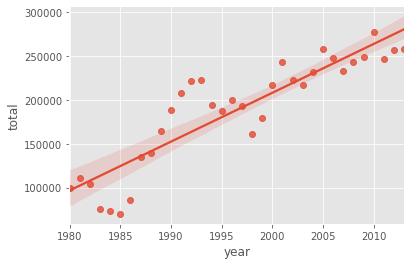

In [91]:
ax = sns.regplot(x='year', y='total', data=df_tot)

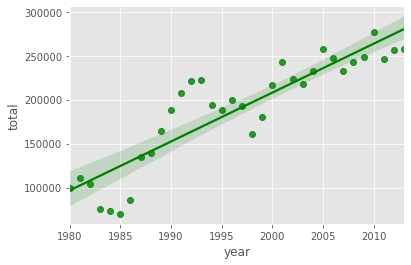

In [92]:
# Change color
ax = sns.regplot(x='year', y='total', data=df_tot, color='green')

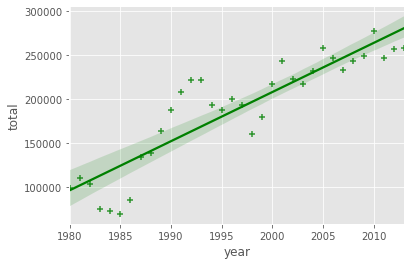

In [93]:
# Change marker type
ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+')

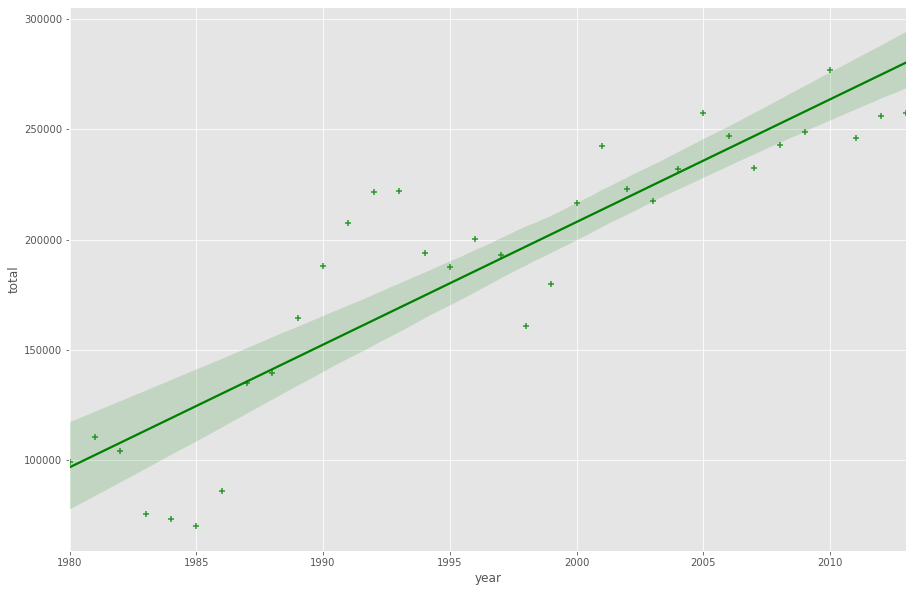

In [95]:
# Make figure larger
plt.figure(figsize=(15, 10))
ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+')

Text(0.5, 1.0, 'Total Immigration to Canada from 1980 - 2013')

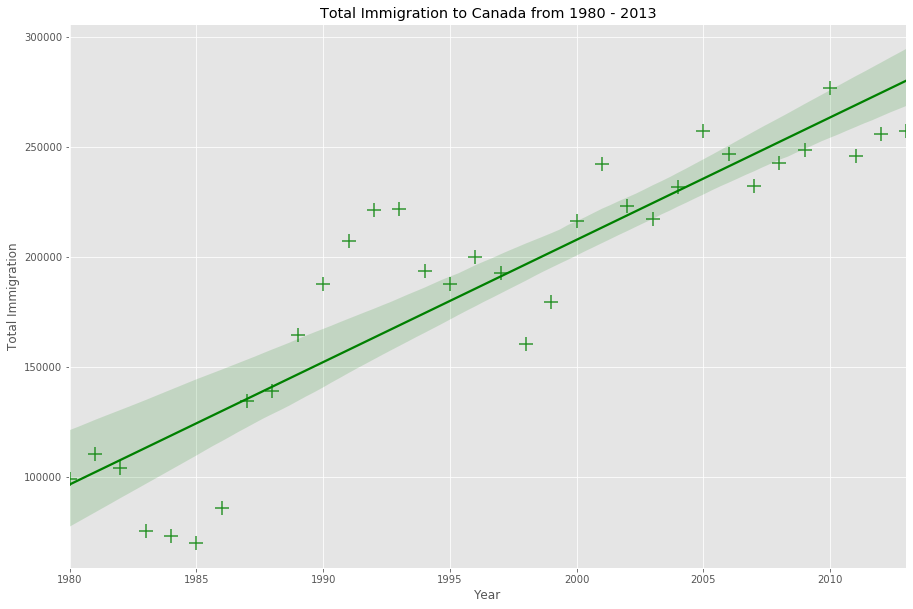

In [99]:
# increase size of markers
plt.figure(figsize=(15, 10))
ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})

ax.set(xlabel='Year', ylabel='Total Immigration') # add x- and y-labels
ax.set_title('Total Immigration to Canada from 1980 - 2013') # add title

Text(0.5, 1.0, 'Total Immigration to Canada from 1980 - 2013')

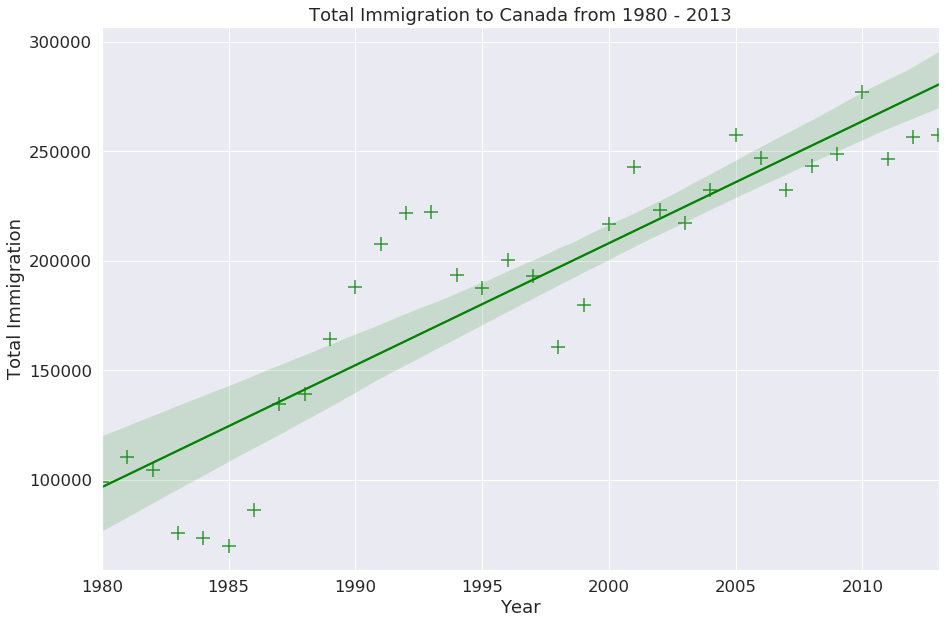

In [102]:
# Increase tickmark labels size
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.5)

ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigration to Canada from 1980 - 2013')

Text(0.5, 1.0, 'Total Immigration to Canada from 1980 - 2013')

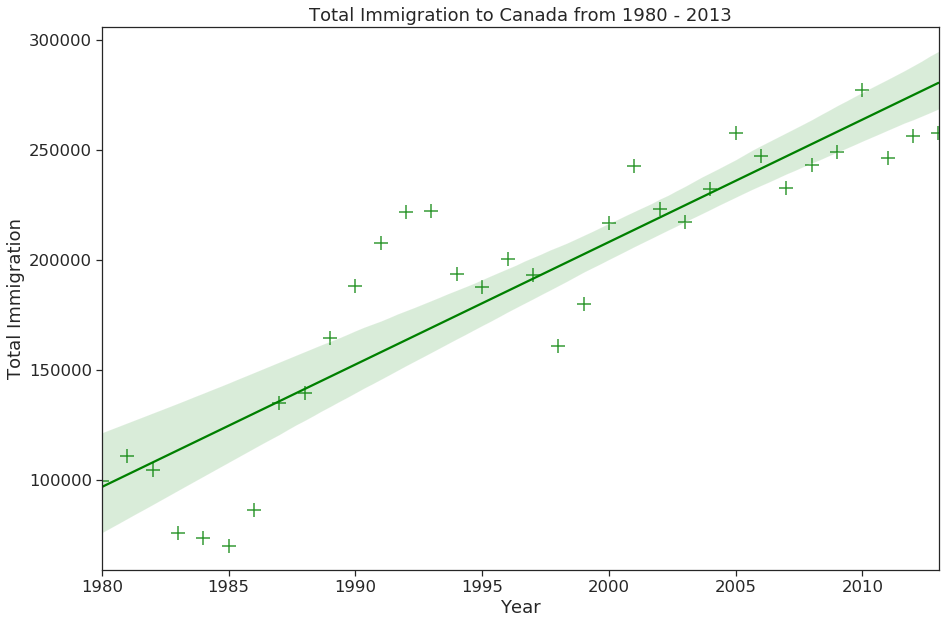

In [103]:
# Change background
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.5)
sns.set_style('ticks') # change background to white background

ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigration to Canada from 1980 - 2013')

Text(0.5, 1.0, 'Total Immigration to Canada from 1980 - 2013')

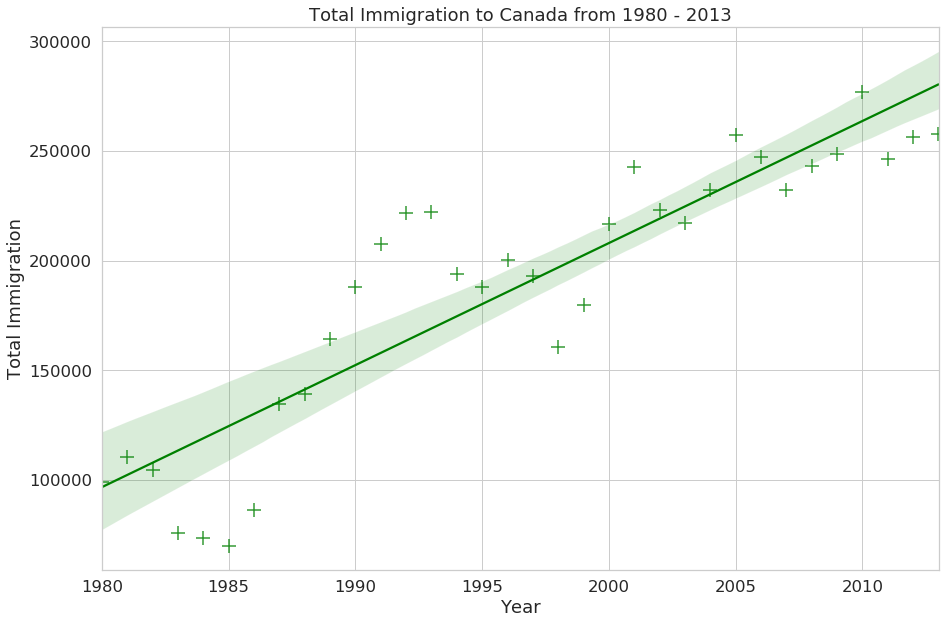

In [104]:
# With gridlines
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.5)
sns.set_style('whitegrid')

ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigration to Canada from 1980 - 2013')

Text(0.5, 1.0, 'Total Immigrationn from Denmark, Sweden, and Norway to Canada from 1980 - 2013')

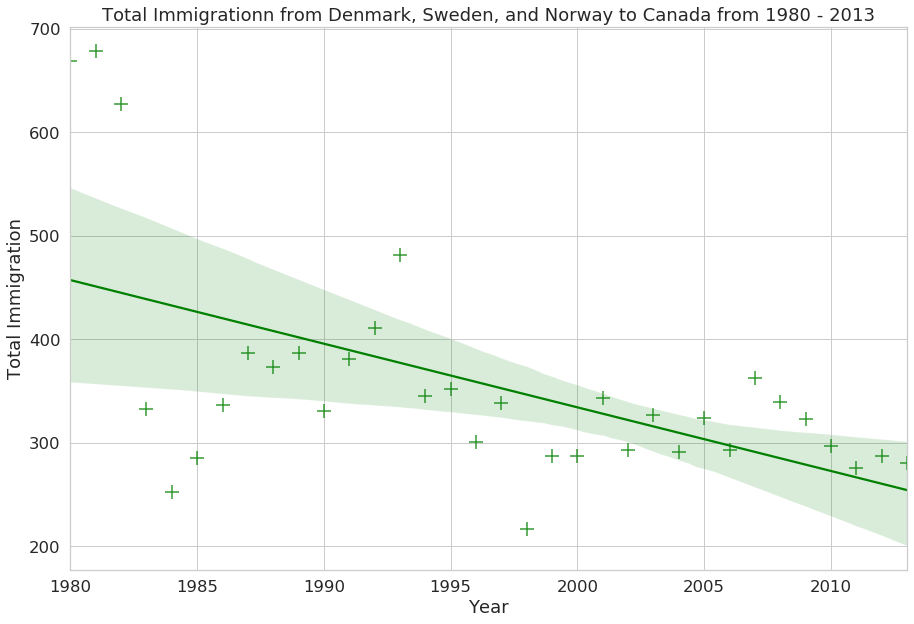

In [107]:
# Regplot for Denmark, Sweden, and Norway

# create df_countries dataframe
df_countries = df_can.loc[['Denmark', 'Norway', 'Sweden'], years].transpose()

# create df_total by summing across three countries for each year
df_total = pd.DataFrame(df_countries.sum(axis=1))

# reset index in place
df_total.reset_index(inplace=True)

# rename columns
df_total.columns = ['year', 'total']

# change column year from string to int to create scatter plot
df_total['year'] = df_total['year'].astype(int)

# define figure size
plt.figure(figsize=(15, 10))

# define background style and font size
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

# generate plot and add title and axes labels
ax = sns.regplot(x='year', y='total', data=df_total, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigrationn from Denmark, Sweden, and Norway to Canada from 1980 - 2013')
